In [72]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils.data as DataLoader
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch.utils.checkpoint import checkpoint


In [73]:
n_embd=768
mlp_dim=3072
patch_size=14
n_layers=6
n_heads=8
dropout=0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [74]:
data_dir='/kaggle/input/plant-village/PlantVillage'

## Classes in the dataset

In [75]:
print(os.listdir(data_dir))
num_classes=len(os.listdir(data_dir))

['Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Pepper__bell___healthy', 'Potato___Late_blight', 'Tomato_Late_blight', 'Potato___Early_blight', 'Tomato__Tomato_mosaic_virus']


## Data Augmentation

In [76]:
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
])

dataset = ImageFolder(data_dir,transform=transform)

In [77]:
train_size=int(0.8*len(dataset))
val_size=int(0.1*len(dataset))
test_size= len(dataset)-train_size-val_size

train_data,val_data,test_data=random_split(dataset,[train_size,val_size,test_size])
print(len(train_data),len(val_data),len(test_data))

16510 2063 2065


In [78]:
img ,label=train_data[2900]
print(img.shape)

torch.Size([3, 224, 224])


## Visualising the data

Class: Tomato_Leaf_Mold , Label: 8


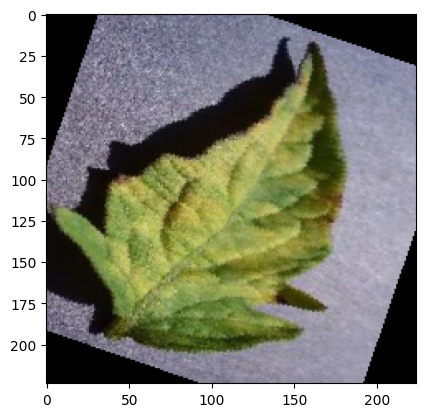

In [79]:
import matplotlib.pyplot as plt
print('Class:',dataset.classes[label],',','Label:',label)
plt.imshow(img.permute(1,2,0))

In [80]:
batch_size=128
train_dl=DataLoader(train_data,batch_size,shuffle=True)
val_dl=DataLoader(val_data,batch_size*2,shuffle=True)
test_dl=DataLoader(test_data,32,shuffle=False)

In [81]:
class PatchEmbeddings(nn.Module):
    def __init__(self,img_size,n_embd,patch_size):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch=nn.Conv2d(3,n_embd,kernel_size=patch_size,stride=patch_size,padding=0)
        self.flatten=nn.Flatten(2,3)
    def forward(self,x):
        x=self.patch(x)
        x=self.flatten(x)
        return x.permute(0,2,1)  

In [82]:
class PositionalEncoding(nn.Module):
    def __init__(self,n_patches,n_embd):
        super().__init__()
        self.pos=nn.Parameter(torch.randn(1,n_patches+1,n_embd),requires_grad=True)
    def forward(self,x):
        return x+self.pos

## Defining Model Architechture


In [83]:
class TransformerEncoder(nn.Module):
    def __init__(self,n_embd,n_heads,mlp_dim,dropout=dropout):
        super().__init__()
        self.l1=nn.LayerNorm(n_embd)
        self.l2=nn.LayerNorm(n_embd)
        self.attn=nn.MultiheadAttention(n_embd,n_heads,dropout=0,batch_first=True)
        self.mlp=nn.Sequential(
            nn.Linear(n_embd,mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim,n_embd),
            nn.Dropout(dropout)
        
        )
    def forward(self,x):
        x=self.l1(x)
        attn_out,_=self.attn(x,x,x)
        x=x+attn_out
        x=self.l2(x)
        mlp_out=self.mlp(x)
        x=x+mlp_out
        
        return x
    

In [84]:
class VisionTransformer(nn.Module):
    def __init__(self,img_size,num_classes,n_embd,patch_size,n_layers,n_heads,mlp_dim,dropout):
        super().__init__()
        self.patchify=PatchEmbeddings(img_size,n_embd,patch_size)
        self.n_patches=self.patchify.num_patches
        self.pos_encodings=PositionalEncoding(self.n_patches,n_embd)
        self.transformer_encoder=nn.ModuleList([TransformerEncoder(n_embd,n_heads,mlp_dim,dropout) for _ in range(n_layers)])
        self.cls_token=nn.Parameter(torch.randn(1,1,n_embd),requires_grad=True)
        self.mlp_head=nn.Sequential(
            nn.LayerNorm(n_embd),
            nn.Linear(n_embd,num_classes)
            
        )
    def forward(self,x):
        batch_size=x.shape[0]
        x=self.patchify(x)
        cls_tokens=self.cls_token.expand(batch_size,-1,-1)
        x=torch.cat([cls_tokens,x],dim=1)
        x=self.pos_encodings(x)

        for layer in self.transformer_encoder:
            x=checkpoint(layer,x,use_reentrant=False)
            
        cls_token_final=x[:,0]
        logits=self.mlp_head(cls_token_final)
        
        return logits

## Train and eval function

In [85]:
@torch.no_grad()
def evaluate(model,val_dl,criterion):
    model.eval()
    total=0
    correct=0
    batch_losses=[]
    for img,label in val_dl:
        img,label=img.to(device),label.to(device)
        logits = model(img)
        loss = criterion(logits, label)
        batch_losses.append(loss)
        _,predicted=torch.max(logits.data,1)
        total+=label.size(0)
        correct+=(predicted==label).sum().item()
    val_loss=torch.stack(batch_losses).mean()
    val_acc=(correct/total)*100
    return {'val_loss':val_loss,'val_acc':val_acc}

def train(n_epochs,lr,model,train_dl,val_dl,criterion,opt_func):
    model.train()
    optimizer=opt_func(model.parameters(),lr)
    history=[]
    for epoch in range(n_epochs):
        train_losses=[]
        total=0
        correct=0
        for img,label in train_dl:
            img,label=img.to(device),label.to(device)
            optimizer.zero_grad()
            logits = model(img)
            loss = criterion(logits, label)
            train_losses.append(loss)
            _,predicted=torch.max(logits.data,1)
            total+=label.size(0)
            correct+=(predicted==label).sum().item()
            loss.backward()
            optimizer.step()
            
        result=evaluate(model,val_dl,criterion)
        train_loss=torch.stack(train_losses).mean()
        train_acc=(correct/total)*100
        result['train_loss']=train_loss
        result['train_acc']=train_acc
        print(f'Epoch:{epoch},train_loss:{result["train_loss"]},train_acc:{result["train_acc"]},val_loss:{result["val_loss"]},val_acc:{result["val_acc"]}')
        history.append(result)
    return history 

In [86]:
model=VisionTransformer(224,num_classes,n_embd,patch_size,n_layers,n_heads,mlp_dim,dropout)
model=model.to(device)

In [87]:
n_epochs=20
optim_func=optim.Adam
lr=3e-5
criterion=nn.CrossEntropyLoss()

## Model Training

In [88]:
history=train(n_epochs,lr,model,train_dl,val_dl,criterion,optim_func)

Epoch:0,train_loss:2.3795130252838135,train_acc:22.1320411871593,val_loss:2.1026790142059326,val_acc:30.5865244789142
Epoch:1,train_loss:1.872321367263794,train_acc:38.82495457298607,val_loss:1.8585354089736938,val_acc:38.923897237033444
Epoch:2,train_loss:1.4474470615386963,train_acc:52.707450030284676,val_loss:1.1858699321746826,val_acc:61.26999515269026
Epoch:3,train_loss:1.1945669651031494,train_acc:60.72683222289521,val_loss:1.0830084085464478,val_acc:64.46921958313136
Epoch:4,train_loss:1.0314347743988037,train_acc:66.03270745003029,val_loss:0.8971360325813293,val_acc:70.96461463887542
Epoch:5,train_loss:0.9373134970664978,train_acc:69.30950938824955,val_loss:0.883995532989502,val_acc:71.25545322346098
Epoch:6,train_loss:0.8138020634651184,train_acc:73.07086614173228,val_loss:0.7434757947921753,val_acc:76.15123606398448
Epoch:7,train_loss:0.7038759589195251,train_acc:76.45669291338582,val_loss:0.6368324756622314,val_acc:77.94474066892874
Epoch:8,train_loss:0.6364988088607788,trai

In [89]:
test_result=evaluate(model,test_dl,criterion)
print(f'Test accuracy is:{test_result["val_acc"]}')

Test accuracy is:91.38014527845037


In [101]:
torch.save(model.state_dict(), 'ViT_classification_weights.pth')

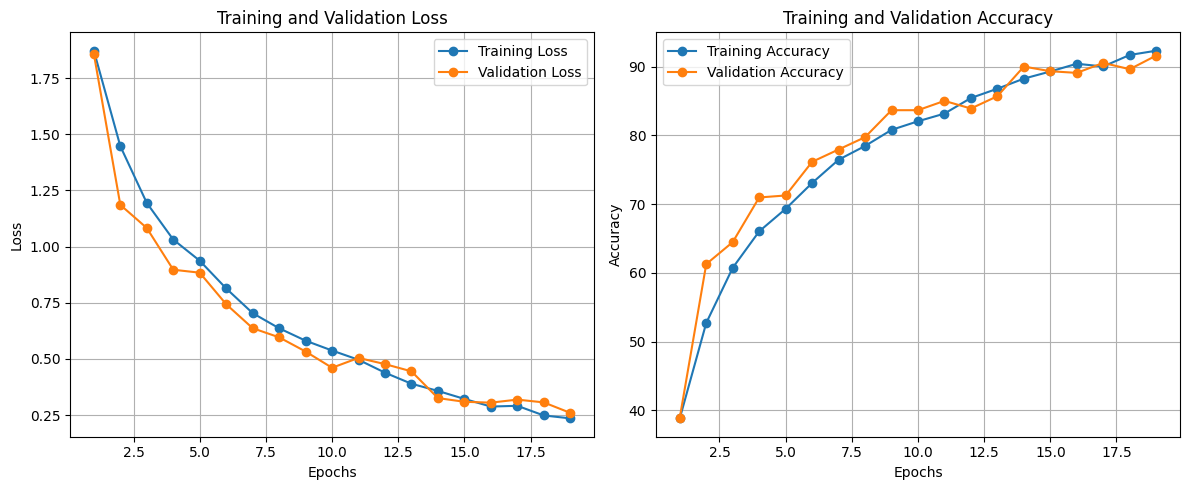

In [98]:
import matplotlib.pyplot as plt

# Assuming history is a dictionary that has 'train_loss', 'val_loss', 'train_acc', and 'val_acc' for each epoch
epoch = list(range(1, 20))  # Adjust this according to your actual number of epochs

# Extract training and validation losses as lists
train_loss = [history[i]["train_loss"].cpu().item() for i in epoch]
val_loss = [history[j]["val_loss"].cpu().item() for j in epoch]

# Extract training and validation accuracies as lists
train_acc = [history[i]["train_acc"] for i in epoch]
val_acc = [history[j]["val_acc"] for j in epoch]

# Plotting Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # Create a subplot for Loss
plt.plot(epoch, train_loss, label='Training Loss', marker='o')
plt.plot(epoch, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plotting Accuracy
plt.subplot(1, 2, 2)  # Create a subplot for Accuracy
plt.plot(epoch, train_acc, label='Training Accuracy', marker='o')
plt.plot(epoch, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


## Visualising Predictions

Prediction: Tomato__Tomato_mosaic_virus
Ground Truth: Tomato__Tomato_mosaic_virus


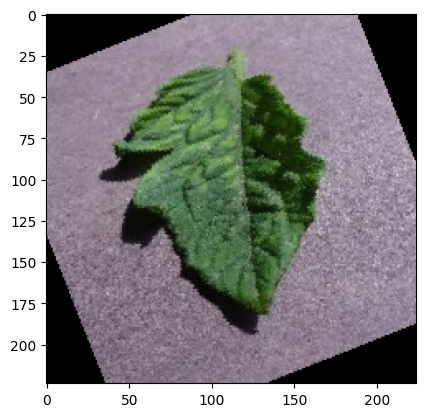

In [109]:
for img,label in test_dl:
    img,label=img.to(device),label.to(device)
    out=model(img)
    _,pred=torch.max(out,dim=1)
    plt.imshow(img[1].permute(1,2,0).cpu().numpy())
    print("Prediction:",dataset.classes[pred[1]])
    print("Ground Truth:",dataset.classes[label[1]])
    break